In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import seaborn as sns

from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score


# Insights Into Workout Efficiency

## Content
1. Abstract  
2. Objectives  
3. Methods  
   3.1 Data Cleaning and preprocessing  
   3.2 Feature Engineering  
   3.3 Exploratory data analysis  
   3.4 Hypothesis Testing  
   3.5 Correlation  
   3.6 Linear Regression and Huber Regression  
   3.7 Logistic Regression  
   3.8 Random Forest classification
4. References
   

## 1. Abstract
This project aims to identify and quantify the key physiological (e.g., BMI, gender), demographic, and workout-specific factors (e.g., exercise type, duration) that significantly influence calorie expenditure during physical activity.Two independent datasets are analyzed to verify whether patterns identified in the first dataset are consistently replicated in the second, thereby ensuring reliability of the findings. The methodology combines statistical hypothesis testing to assess variable significance, correlation analysis to explore interdependencies, and predictive modeling using linear regression to estimate calories burned. Additionally, logistic regression is applied to classify calorie burn levels into categories, enabling a more interpretable assessment of workout effectiveness. 

## 2. Objectives
1. Identify the impact of physiological and workout-related variables (such as BMI, workout type, and gender) on calorie expenditure through statistical hypothesis testing.

2. Compare two distinct datasets to detect consistent patterns and ensure robustness of results.

3. Develop and evaluate a linear regression and huber regression models to accurately estimate calories burned based on individual and workout characteristics and compare which model perform better.

4. Implement a logistic regression classification model compared with Random Forest classification to categorize calorie burn levels, enhancing interpretation of workout intensity.

## 3. Methods

### 3.1 Data cleaning and preprocessing

In [2]:
df1 = pd.read_csv("gym_members_exercise_tracking.csv")
df1.columns = df1.columns.str.replace(" ","_")
df1.columns = df1.columns.str.lower()
df1["gender"] =df1["gender"].astype(str)
df1["workout_type"] =df1["workout_type"].astype(str)
df1["session_duration_(hours)"] = round( df1["session_duration_(hours)"] * 60 ,)
df1.rename(columns={"session_duration_(hours)": "session_duration_(mins)"}, inplace=True)
df1.isna().sum() # no missing values
df1.isnull().sum()


age                              0
gender                           0
weight_(kg)                      0
height_(m)                       0
max_bpm                          0
avg_bpm                          0
resting_bpm                      0
session_duration_(mins)          0
calories_burned                  0
workout_type                     0
fat_percentage                   0
water_intake_(liters)            0
workout_frequency_(days/week)    0
experience_level                 0
bmi                              0
dtype: int64

In [3]:
df2 = pd.read_csv("workout_fitness_tracker_data.csv")
df2.columns = df2.columns.str.replace(" ","_")
df2.columns = df2.columns.str.lower()
df2["gender"] =df2["gender"].astype(str)
df2["workout_type"] =df2["workout_type"].astype(str) 
df2["workout_intensity"] =df2["workout_intensity"].astype(str)
df2["mood_before_workout"] =df2["mood_before_workout"].astype(str)
df2["mood_after_workout"] =df2["mood_after_workout"].astype(str)
df2.isna().sum() # no missing values
df2.isnull().sum()


user_id                     0
age                         0
gender                      0
height_(cm)                 0
weight_(kg)                 0
workout_type                0
workout_duration_(mins)     0
calories_burned             0
heart_rate_(bpm)            0
steps_taken                 0
distance_(km)               0
workout_intensity           0
sleep_hours                 0
water_intake_(liters)       0
daily_calories_intake       0
resting_heart_rate_(bpm)    0
vo2_max                     0
body_fat_(%)                0
mood_before_workout         0
mood_after_workout          0
dtype: int64

### 3.2  Feature engineering

Calories burned alone only explains the total energy expenditure, which is heavily influenced by how long a person works out. Workout efficiency normalizes this for time, creating a direct measure of intensity. This new variable is a much better predictor of the quality of a workout than the raw calories burned feature.

BMI also is not so understandable for people who are not familiar with the domain. Grouping into two groups will represent the data in a easy and more intuitive way. It will be used later for observations if the BMI has a effect on a burned calories. By grouping data, the model will capture non-linear patterns (if exist) that would be difficult to detect otherwise.

In [4]:
def age_group(age):
    if age < 20: return 'teen'
    elif age < 40: return 'young'
    elif age < 50: return 'middle'
    else: return 'seniour'






df1["workout_efficiency"] = df1["calories_burned"] / df1["session_duration_(mins)"]
df1['age_group'] = df1['age'].apply(age_group)

threshold_bmi1 = df1['bmi'].median()
df1['bmi_category'] = df1['bmi'].apply(lambda x: 'Low' if x < threshold_bmi1 else 'High')




df2["workout_efficiency"] = df2["calories_burned"] / df2["workout_duration_(mins)"]
df2['age_group'] = df2['age'].apply(age_group)

df2['bmi'] = df2['weight_(kg)'] / (   ((df2['height_(cm)'] / 100) ** 2)   )
threshold_bmi2 = df2['bmi'].median()
df2['bmi_category'] = df2['bmi'].apply(lambda x: 'Low' if x < threshold_bmi2 else 'High')


### 3.3 Exploratory data analysis


Age directly impacts metabolism, heart rate, and overall physical capacity. Younger individuals often have higher metabolic rates and can sustain more intense workouts, which can affect the number of calories burned.

By grouping the people into few age groups is often easier to understand the results.

A histogram of ages provides a visual representation of the frequency distribution of a single numerical variable.
The shape of the histogram can reveal if the data is skewed (if younger people are more than older ones) or if there are any unusual outliers (people of particiluar age train much more than others).


A feature like workout efficiency (calories burned per minute) was chosen for analysis because it provides a normalized view of exercise intensity that cannot be captured by raw calorie burn or session duration alone. While calories burned is heavily influenced by how long a workout lasts, efficiency adjusts for time and highlights how effective a workout is on a per-minute basis.
The shape of the workout efficiency distribution can reveal whether most participants exercise at similar intensities, certain groups systematically differ, or if there are unusual outliers such as extremely high-intensity sessions.


A comparison of two dataset will be performed for double checking the results.


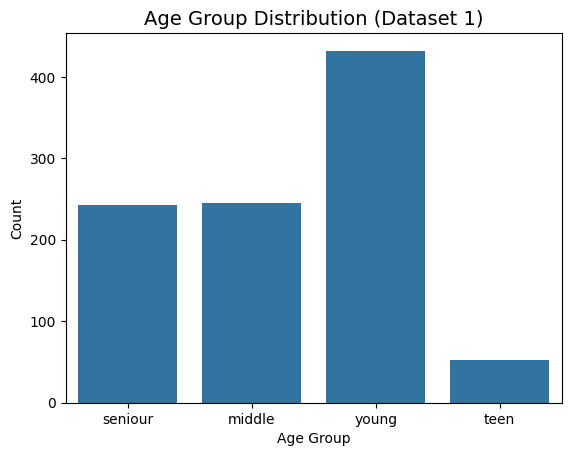

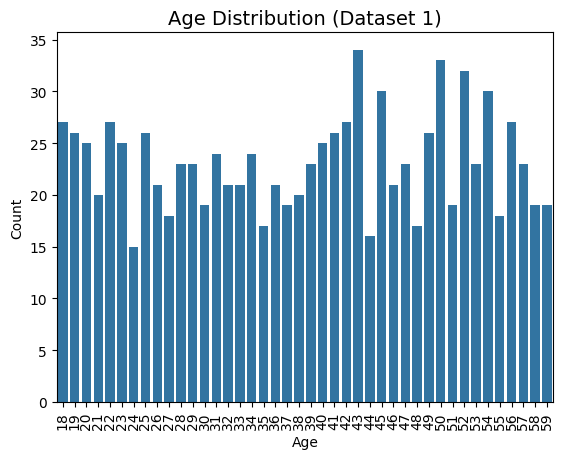

In [5]:
sns.countplot(data=df1, x='age_group')
plt.title('Age Group Distribution (Dataset 1)', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


sns.countplot(data=df1, x='age')
plt.title('Age Distribution (Dataset 1)', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



In [6]:
print (df1['age'].describe())
print(f"skew: {df1['age'].skew()}")
print(f"kurt: {df1['age'].kurt()}")

count    973.000000
mean      38.683453
std       12.180928
min       18.000000
25%       28.000000
50%       40.000000
75%       49.000000
max       59.000000
Name: age, dtype: float64
skew: -0.07786396227519052
kurt: -1.2150760810621073


The mean age is approximately 38.7 years and standard deviation = 12.18 years, indicating a moderately spread adult population.

Most of training people are between 30 and 50 years old.

The distribution’s skewness is approximately -0.078, which is very close to zero. This slight negative skew indicates a nearly symmetric distribution with a marginal tail extending toward younger ages. The kurtosis value of -1.215 suggests a platykurtic distribution, meaning the age data has lighter tails and is flatter than a normal distribution. This implies fewer extreme values or outliers in the age range.

Taken together, these statistics reveal a predominantly middle-aged population with a balanced age distribution, minimal skewness, and reduced occurrence of extreme ages.

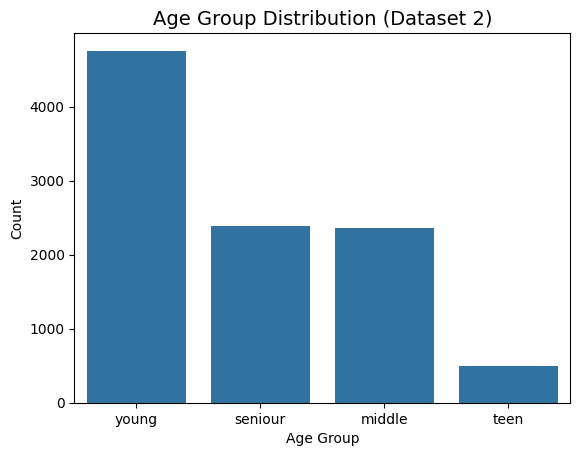

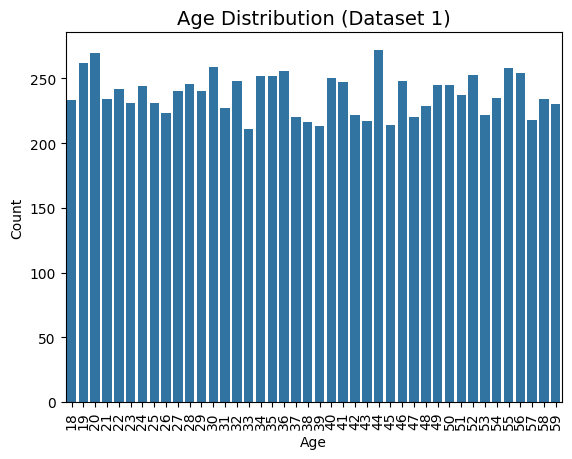

In [7]:
sns.countplot(data=df2, x='age_group')
plt.title('Age Group Distribution (Dataset 2)', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()
df2['age_group'].describe()

sns.countplot(data=df2, x='age')
plt.title('Age Distribution (Dataset 1)', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [8]:
print (df2['age'].describe())
print(f"skew: {df2['age'].skew()}")
print(f"kurt: {df2['age'].kurt()}")

count    10000.000000
mean        38.390100
std         12.171637
min         18.000000
25%         28.000000
50%         38.000000
75%         49.000000
max         59.000000
Name: age, dtype: float64
skew: 0.006228758529151929
kurt: -1.2133849349327688


The mean age is approximately 38.4 years, and the standard deviation is 12.17 years, indicating a wide but consistent spread of ages similar to the first dataset.

Most of training people are between 30 and 50 years old.

The skewness value is approximately 0.006, effectively zero, which confirms the age distribution is nearly perfectly symmetric. The kurtosis is -1.213, indicating a platykurtic distribution that is flatter than a normal distribution, with lighter tails and fewer extreme age values.



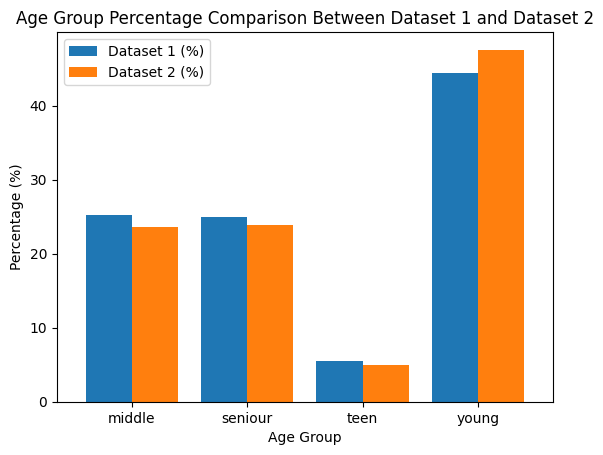

In [9]:


age_percent_compare = pd.DataFrame({
    'Dataset 1 (%)': (df1['age_group'].value_counts(normalize=True) * 100).sort_index(),
    'Dataset 2 (%)': (df2['age_group'].value_counts(normalize=True) * 100).sort_index()
})


age_percent_compare.plot(kind='bar', width=0.8)
plt.title('Age Group Percentage Comparison Between Dataset 1 and Dataset 2')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend()


#### Interpretation
The age group distributions across both datasets display a remarkably similar pattern, indicating consistent demographic representation between the two data sources. This alignment reduces concerns about sampling bias and suggests that the datasets reliably reflect the target population’s age structure.

In both datasets, the majority of participants are concentrated within the 20-40 age group, which constitute about 45% of the sample. This concentration highlights a predominance of middle-aged adults engaging in the recorded workouts.

Such an age distribution implies that subsequent analyses and modeling results will primarily capture patterns relevant to this middle-age demographic. 

Descriptive Statistics for Workout Efficiency (kcal/min)
count    973.000000
mean      12.006791
std        1.451079
min        8.982759
25%       10.926829
50%       11.933333
75%       13.041096
max       15.593750
Name: workout_efficiency, dtype: float64

Mean Efficiency by Gender
gender
Female    11.406685
Male      12.549353
Name: workout_efficiency, dtype: float64


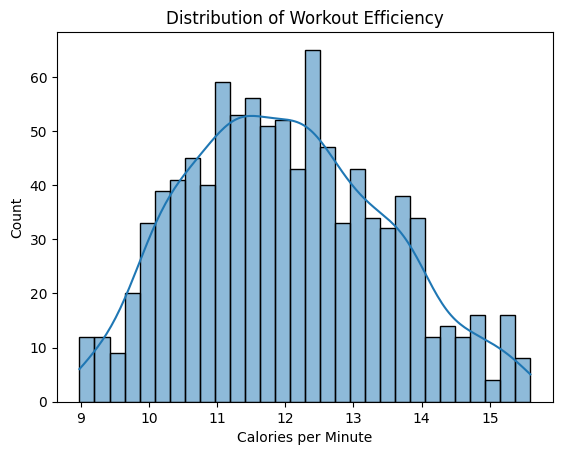

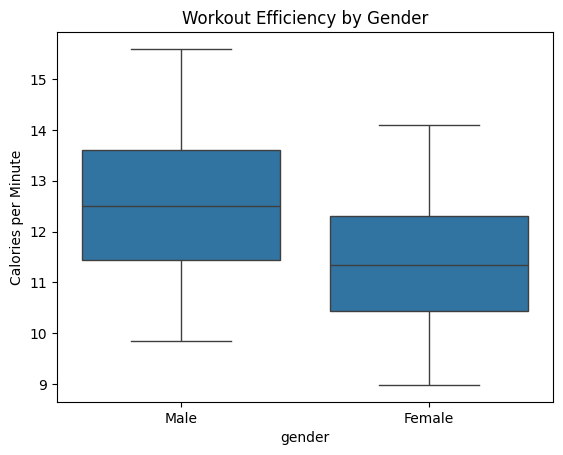

In [46]:

print("Descriptive Statistics for Workout Efficiency (kcal/min)")
print(df1["workout_efficiency"].describe())


print("\nMean Efficiency by Gender")
print(df1.groupby("gender")["workout_efficiency"].mean())



sns.histplot(df1["workout_efficiency"], bins=30, kde=True)
plt.title("Distribution of Workout Efficiency")
plt.xlabel("Calories per Minute")
plt.show()

sns.boxplot(x="gender", y="workout_efficiency", data=df1)
plt.title("Workout Efficiency by Gender")
plt.ylabel("Calories per Minute")
plt.show()



1. The mean and median are very close, suggesting that the distribution of workout efficiency is approximately symmetrical.
2. The overall range (~6.6 kcal/min) is relatively tight, implying no extreme outliers or massive variation in workout intensity.
3. The Quartiles shows a narrow clustering around 12 kcal/min.
4. The gap between males and females (~10% difference) suggests men burn a bit more calories per minute on average. The absolute difference of 1.14 kcal/min in practical means, there is no significant difference between the groups.

=== Descriptive Statistics for Workout Efficiency (kcal/min) ===
count    10000.000000
mean        12.820667
std         13.138330
min          0.840336
25%          5.032282
50%          8.643544
75%         15.032528
max         98.700000
Name: workout_efficiency, dtype: float64
skew: 2.633948419661831
kurt: 8.6224350412384

 Mean Efficiency by Gender
gender
Female    12.854321
Male      13.105853
Other     12.505204
Name: workout_efficiency, dtype: float64


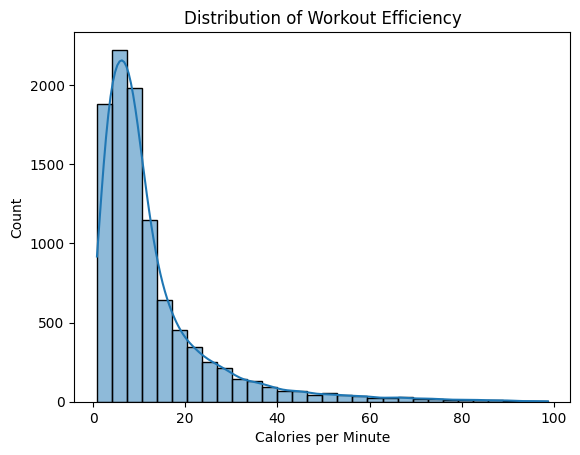

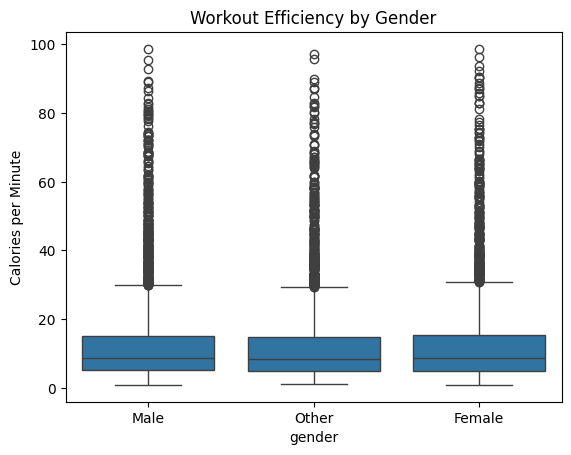

In [45]:
print("Descriptive Statistics for Workout Efficiency (kcal/min)")
print(df2["workout_efficiency"].describe())
print(f"skew: {df2["workout_efficiency"].skew()}")
print(f"kurt: {df2["workout_efficiency"].kurt()}")


print("\n Mean Efficiency by Gender")
print(df2.groupby("gender")["workout_efficiency"].mean())



sns.histplot(df2["workout_efficiency"], bins=30, kde=True)
plt.title("Distribution of Workout Efficiency")
plt.xlabel("Calories per Minute")
plt.show()

sns.boxplot(x="gender", y="workout_efficiency", data=df2)
plt.title("Workout Efficiency by Gender")
plt.ylabel("Calories per Minute")
plt.show()



1. Most participants have efficiencies between 5–15 kcal/min.
2. The mean is around 13 kcal/min.
3. Very large STD(13.13), showing extreme variability across workouts
4. Some sessions reach nearly 100 kcal/min, which is unusually high. These outliers coud be caused by wrong data (very short calorie-dense sessions) or workouts done by professional sportists.
5. The distribution is highly skewed (2.63) with long right tail.
6. No gap between the gender.

#### Interpretation

1. The first dataset seems to be more balanced without extreme otliers.
2. The second dataset is more unbalanced with some hight outliers
3. Both datasets have mean around 12 kcal/min
4. Both datasets showed there is no significant difference between the gender.

### 3.4 Hypothesis Testing

Hypothesis testing is method to determine if an observed pattern in a sample dataset is likely to reflect a true effect in the larger population, or if it is merely due to random chance.

Different statistical methods are used in order to understand if some features of the data set are impacting the calories burn.

For comparing the means of a continuous variable (like calories burned) between exactly two groups most suitable test is the T-test.Using multiple t-tests for more than two groups would inflate the risk of a error.

By performing a single ANOVA test efficiently determines if at least one of the workout types has a mean calorie burn that is significantly different from the others. This avoids the problem of accumulated errors from multiple comparisons.


Since the workout types and gender are categorical features most suitable method to determine if there is a significant association between the variables is Chi-Square test.

#### 1. Does BMI have a significant effect on calories burned?
    H₀ (Null Hypothesis): BMI has no effect on calories burned.
    H₁ (Alternative Hypothesis): BMI has a significant effect on calories burned.

T-statistic: -2.0694307830064105, P-value: 0.0387697408453499
Null hypothesis rejected. (p < 0.05, |t| > 2). BMI has a meaningful effect on calories burned.
Cohen's d: 0.133


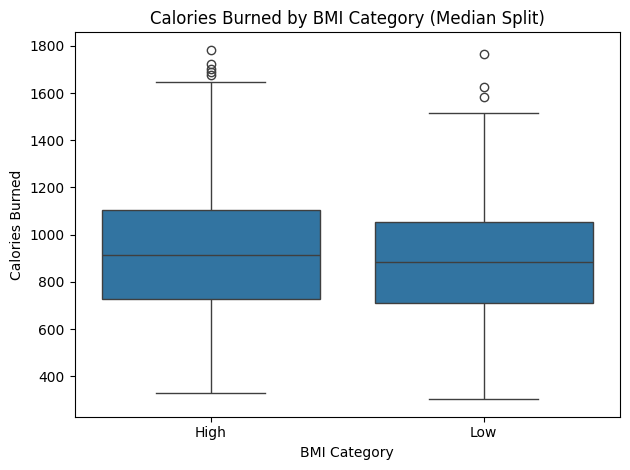

In [10]:
# T-test dataset 1
group_low_bmi1 = df1[df1['bmi_category'] == 'Low']['calories_burned']
group_high_bmi1 = df1[df1['bmi_category'] == 'High']['calories_burned']

t_stat, p_val = ttest_ind(group_low_bmi1, group_high_bmi1)

print(f"T-statistic: {t_stat}, P-value: {p_val}")
if p_val < 0.05 and (t_stat < -2 or t_stat > 2):
    print("Null hypothesis rejected. (p < 0.05, |t| > 2). BMI has a meaningful effect on calories burned.")
elif p_val < 0.05 and (-2 <= t_stat <= 2):
    print("Null hypothesis rejected. Statistical significance found (p < 0.05), but effect size is small (|t| ≤ 2).")
else:
    print("Null hypothesis accepted. No statistically significant difference found (p ≥ 0.05). BMI does not appear to affect calories burned.")


mean_diff1 = group_high_bmi1.mean() - group_low_bmi1.mean()
pooled_std1 = np.sqrt((group_high_bmi1.std()**2 + group_low_bmi1.std()**2) / 2)
cohens_d1 = mean_diff1 / pooled_std1

print(f"Cohen's d: {cohens_d1:.3f}")

sns.boxplot(x='bmi_category', y='calories_burned', data=df1)
plt.title('Calories Burned by BMI Category (Median Split)')
plt.xlabel('BMI Category')
plt.ylabel('Calories Burned')
plt.tight_layout()
plt.show()

T-statistic: 2.0897590476416315, P-value: 0.03666465736266505
Null hypothesis rejected. (p < 0.05, |t| > 2). BMI has a meaningful effect on calories burned.
Cohen's d: -0.042


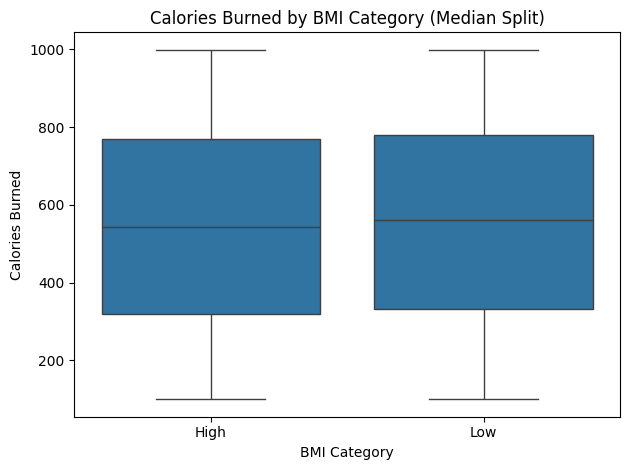

In [11]:

# T-test dataset 2
group_low_bmi2 = df2[df2['bmi_category'] == 'Low']['calories_burned']
group_high_bmi2 = df2[df2['bmi_category'] == 'High']['calories_burned']

t_stat2, p_val2 = ttest_ind(group_low_bmi2, group_high_bmi2)

print(f"T-statistic: {t_stat2}, P-value: {p_val2}")
if p_val2 < 0.05 and (t_stat2 < -2 or t_stat2 > 2):
    print("Null hypothesis rejected. (p < 0.05, |t| > 2). BMI has a meaningful effect on calories burned.")
elif p_val2 < 0.05 and (-2 <= t_stat2 <= 2):
    print("Null hypothesis rejected. Statistical significance found (p < 0.05), but effect size is small (|t| ≤ 2).")
else:
    print("Null hypothesis accepted. No statistically significant difference found (p ≥ 0.05). BMI does not appear to affect calories burned.")



mean_diff = group_high_bmi2.mean() - group_low_bmi2.mean()
pooled_std = np.sqrt((group_high_bmi2.std()**2 + group_low_bmi2.std()**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")


sns.boxplot(x='bmi_category', y='calories_burned', data=df2)
plt.title('Calories Burned by BMI Category (Median Split)')
plt.xlabel('BMI Category')
plt.ylabel('Calories Burned')
plt.tight_layout()
plt.show()

#### Interpretation:
The t-test indicates a statistically significant relationship between BMI and calories burned (p < 0.05), suggesting that BMI does affect calorie expenditure. However, the boxplot shows similar medians and overlapping interquartile ranges for both BMI groups. This apparent contradiction occurs because boxplots highlight medians and spread, not mean differences, while the t-test is sensitive to even small differences in group means, especially with large sample sizes or low variance.

Although the t-test indicates a statistically significant difference in calories burned between BMI groups, the effect size (Cohen's d (–0.042 and 0,13) < 0.2) is negligible. This means that while the result is statistically detectable, the actual difference between the groups is so small that it is not practically meaningful.

This aligns with what boxplot visually shows — nearly identical distributions and medians. The statistical significance may be due to a large sample size or low data variability, both of which can make even tiny differences statistically detectable.

Consistent results across both datasets support the rejection of the null hypothesis, confirming a statistically **insignificant** association between BMI and calories burned.

#### 2. Do different workout types lead to different calorie burn?
    H₀: All workout types have the same calorie burn.
    H₁: At least one workout type differs.

 Null hypothessis accepted.No statistically significant difference found (F = 0.95, p = 0.416). The variation in calories burned across workout types is likely due to random chance.


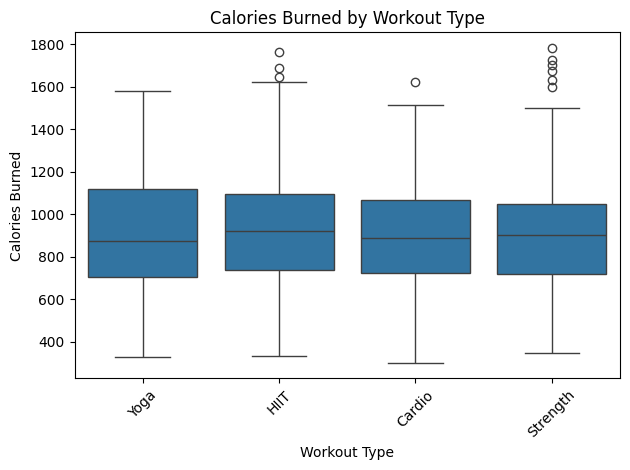

In [12]:
# one-way ANOVA (Analysis of Variance) for dataset 1
types = df1['workout_type'].unique()
groups = [df1[df1['workout_type'] == t]['calories_burned'] for t in types]

f_stat, p_val = f_oneway(*groups)

if p_val < 0.05 :
    print(f" Null hypothessis rejected. (F = {f_stat:.2f}, p < 0.05). This suggests that at least one workout type leads to a different calorie burn.")
else:
    print(f" Null hypothessis accepted.No statistically significant difference found (F = {f_stat:.2f}, p = {p_val:.3f}). The variation in calories burned across workout types is likely due to random chance.")


sns.boxplot(x='workout_type', y='calories_burned', data=df1)
plt.title('Calories Burned by Workout Type')
plt.xlabel('Workout Type')
plt.ylabel('Calories Burned')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Null hypothessis accepted.No statistically significant difference found (F = 0.42, p = 0.836). The variation in calories burned across workout types is likely due to random chance.


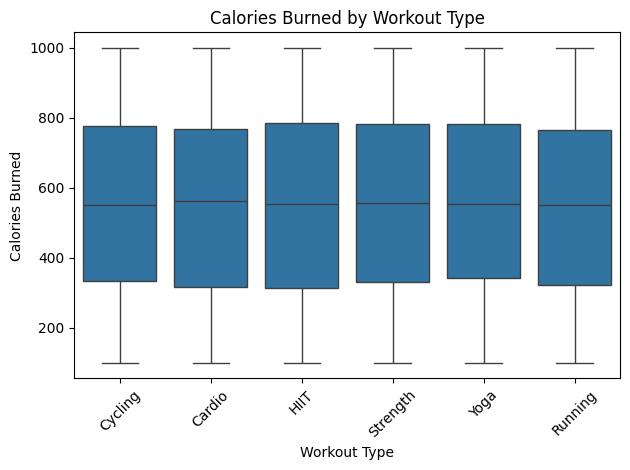

In [13]:
# one-way ANOVA (Analysis of Variance) for dataset 2

types = df2['workout_type'].unique()
groups = [df2[df2['workout_type'] == t]['calories_burned'] for t in types]

f_stat, p_val = f_oneway(*groups)

if p_val < 0.05 :
    print(f" Null hypothessis rejected. (F = {f_stat:.2f}, p < 0.05). This suggests that at least one workout type leads to a different calorie burn.")
else:
    print(f" Null hypothessis accepted.No statistically significant difference found (F = {f_stat:.2f}, p = {p_val:.3f}). The variation in calories burned across workout types is likely due to random chance.")


sns.boxplot(x='workout_type', y='calories_burned', data=df2)
plt.title('Calories Burned by Workout Type')
plt.xlabel('Workout Type')
plt.ylabel('Calories Burned')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Interpretation
Consistent results across both datasets support the acceptance of the null hypothesis, confirming that different workouts  do not lead to different calories burn.

#### 3. Does gender influence the choice of workout type?
    H₀: Gender and workout type are independent — gender does not influence workout preference.
    H₁: Gender and workout type are not independent — gender does influence workout preference.

Chi-Square Statistic: 1.4
Degrees of Freedom: 3
P-value: 0.7052

Null hypothessis accepted. No statistically significant association. Gender and workout type appear independent.


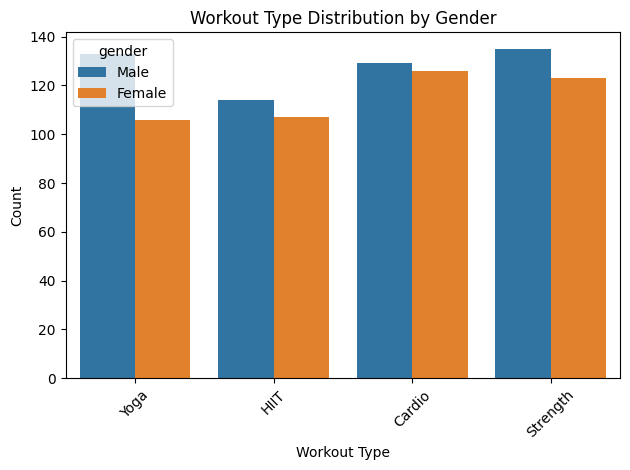

In [14]:
# Chi-Square Test of Independence for datase 1

contingency_table = pd.crosstab(df1['gender'], df1['workout_type'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", round(chi2, 2))
print("Degrees of Freedom:", dof)
print("P-value:", round(p, 4))
print()
if p < 0.05:
    print(f"Null hypothessis rejected. There is a statistically significant association between gender and workout type. The Chi-Square value of {chi2:.2f} indicates a notable deviation. With {dof} degrees of freedom, this suggests that gender likely influences workout preferences across multiple categories.")
else:
    print("Null hypothessis accepted. No statistically significant association. Gender and workout type appear independent.")



sns.countplot(data=df1, x='workout_type', hue='gender')
plt.title('Workout Type Distribution by Gender')
plt.xlabel('Workout Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Chi-Square Statistic: 18.46
Degrees of Freedom: 10
P-value: 0.0476

Null hypothessis rejected. There is a statistically significant association between gender and workout type. The Chi-Square value of 18.46 indicates a notable deviation. With 10 degrees of freedom, this suggests that gender likely influences workout preferences across multiple categories.


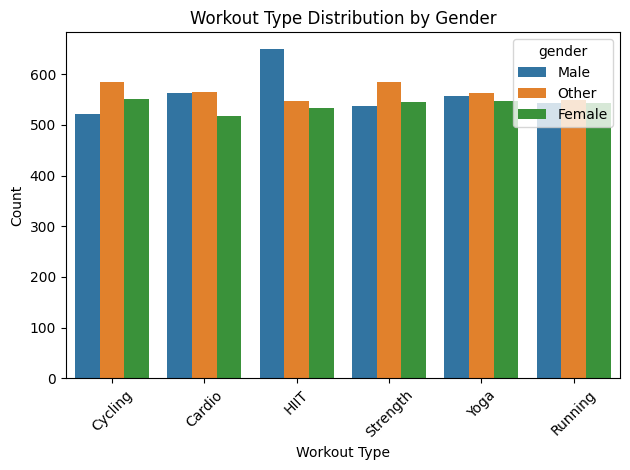

In [15]:
# Chi-Square Test of Independence for datase 1

contingency_table = pd.crosstab(df2['gender'], df2['workout_type'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", round(chi2, 2))
print("Degrees of Freedom:", dof)
print("P-value:", round(p, 4))
print()
if p < 0.05:
    print(f"Null hypothessis rejected. There is a statistically significant association between gender and workout type. The Chi-Square value of {chi2:.2f} indicates a notable deviation. With {dof} degrees of freedom, this suggests that gender likely influences workout preferences across multiple categories.")
else:
    print("Null hypothessis accepted. No statistically significant association. Gender and workout type appear independent.")



sns.countplot(data=df2, x='workout_type', hue='gender')
plt.title('Workout Type Distribution by Gender')
plt.xlabel('Workout Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Interpretation
Based on mixed evidence, it cannot be confidently generalized that gender influences workout type across all contexts. While Dataset 2 shows a statistically significant association between gender and workout type, Dataset 1 does not. Furthermore, even in both datasets, the visual distribution of most workout preferences appears similar across genders.



### 3.5 Correlation

 A correlation matrix is used to quantify the strength and direction of the linear relationship between all features.
 The objective is to identify and quantify the key factors that significantly influence calorie expenditure.

Understanding the correlations between variables is a first step in building a linear regression model. Variables with high correlations are often good candidates for inclusion in a predictive model.

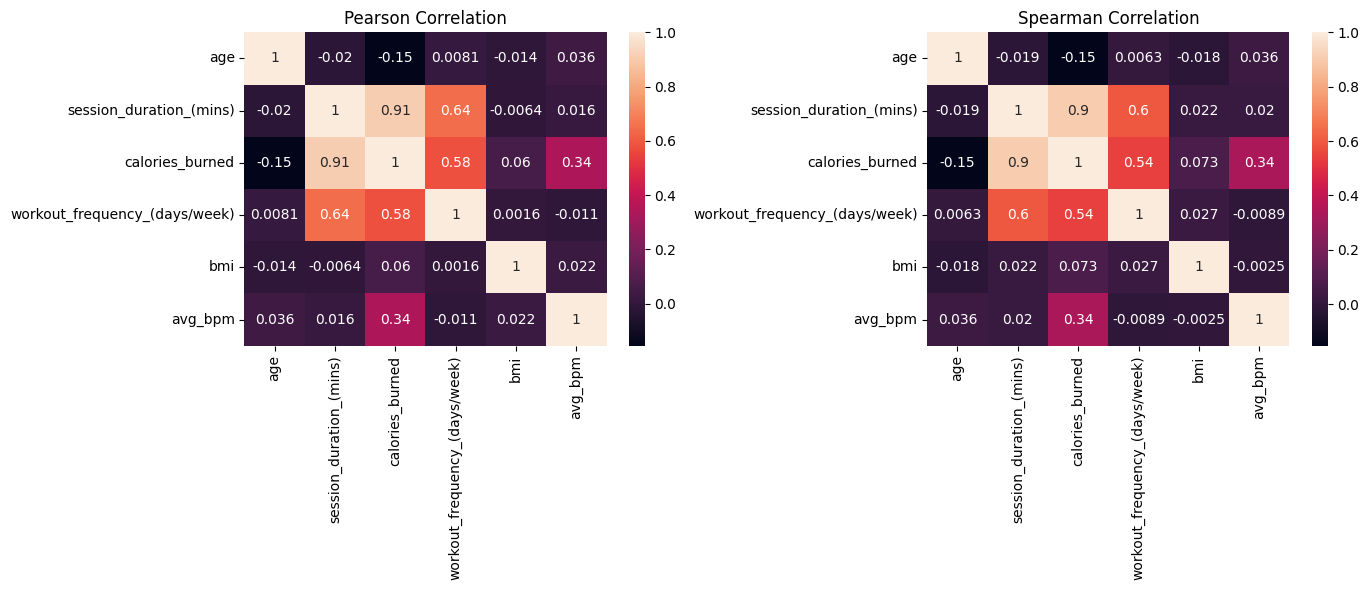

In [16]:
corr_df1 = df1[["age", "session_duration_(mins)", "calories_burned" , "workout_frequency_(days/week)", "bmi", "avg_bpm"]]
corr_matrix = corr_df1.corr()
corr_matrix_spearman = corr_df1.corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(14,6))


sns.heatmap(corr_matrix, annot=True, ax=axes[0])
axes[0].set_title("Pearson Correlation")

sns.heatmap(corr_matrix_spearman, annot=True, ax = axes[1])
axes[1].set_title("Spearman Correlation")



plt.tight_layout()
plt.show()

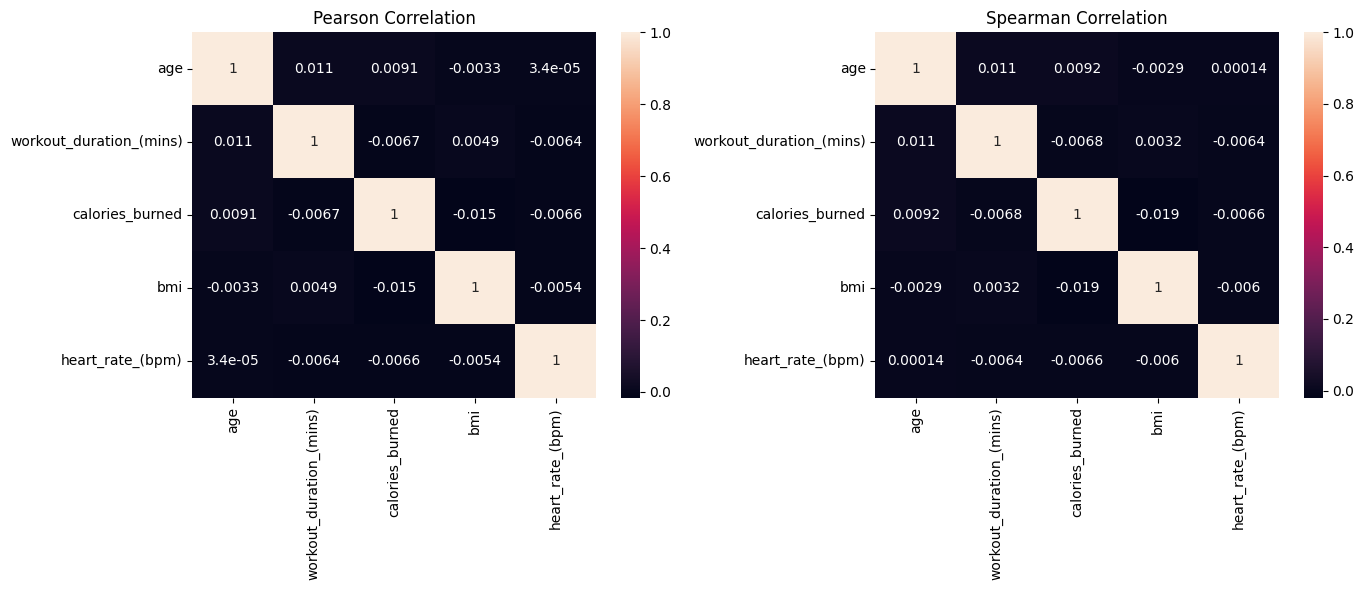

In [17]:
corr_df2 = df2[["age", "workout_duration_(mins)", "calories_burned", "bmi", "heart_rate_(bpm)"]]
corr_matrix = corr_df2.corr()
corr_matrix_spearman = corr_df2.corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(14,6))


sns.heatmap(corr_matrix, annot=True, ax=axes[0])
axes[0].set_title("Pearson Correlation")

sns.heatmap(corr_matrix_spearman, annot=True, ax = axes[1])
axes[1].set_title("Spearman Correlation")



plt.tight_layout()
plt.show()


Session duration is the clearest, largest driver of calories burned in the first datasets (strong linear relationship). Thats why it will be used as a predictor in the Linear regression below.

In order to understand the reason behind the low correlations between the burned calories in the second dataset a distribution analysis will be performed.

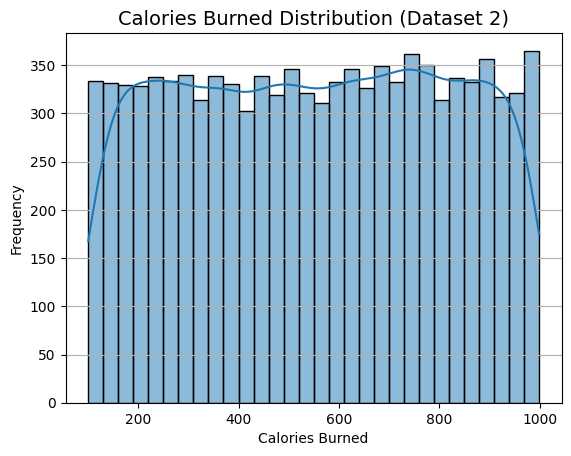

In [18]:


sns.histplot(df2['calories_burned'], bins=30, kde=True)
plt.title('Calories Burned Distribution (Dataset 2)', fontsize=14)
plt.xlabel('Calories Burned')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

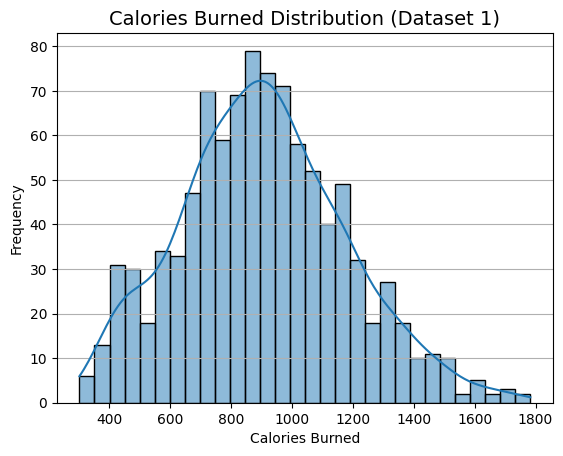

In [19]:
sns.histplot(df1['calories_burned'], bins=30, kde=True)
plt.title('Calories Burned Distribution (Dataset 1)', fontsize=14)
plt.xlabel('Calories Burned')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#### Interpretation
Dataset 2 has flat and symmetry distribution, which means the data lacks a strong central tendency and clear outliers, which makes it statistically improbable for a tight linear relationship to be found between variables.Because of the this only Dataset 1, which is normally distributed will be used for further observations.

### 3.6 Linear regression

For the purpose of predicting the burned calories a linear regression will be used, because it is a fundamental and easily interpretable model. It serves as an excellent baseline model to establish an initial benchmark for the project's predictive accuracy.

Linear regression model is compared to Huber Regression, because Huber Regression is a more robust model that can handle outliers more effectively than standard linear regression. This is particularly useful if there are  exceptionally high or low calorie burn that could skew the results of a simple linear model.

Both models will be validated through the standard metrics


95% Confidence Intervals for Linear Regression Coefficients:
           Lower Bound  Upper Bound
Intercept          NaN          NaN
Slope              NaN          NaN
LR Model intercept: -5.57
LR Coefficient for session_duration_(mins): 12.07

Huber intercept: -7.51
Huber Coefficient for session_duration_(mins): 12.04


SUMMARY COMPARISON
Metric               Linear Reg      Huber Reg      
--------------------------------------------------
Intercept            -5.57           -7.51          
Coefficient          12.07           12.04          
Explained variance   0.82            0.82           
MSE                  15292.25        15343.95       
RMSE                 123.66          123.87         
MAE                  94.99           94.97          
R²                   0.817           0.816          


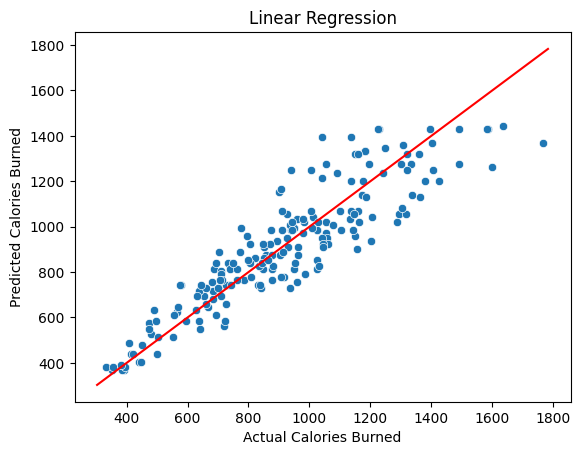

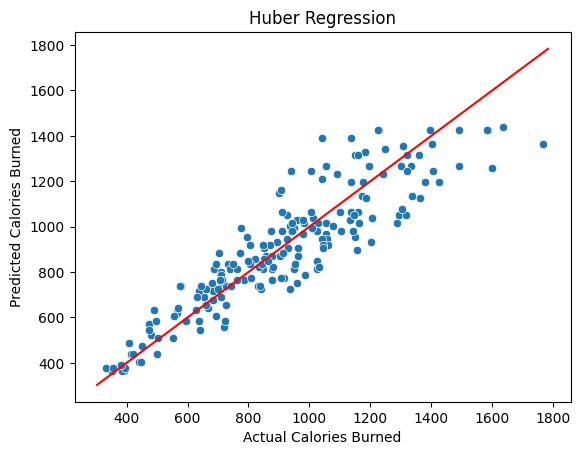

In [22]:
X = df1[['session_duration_(mins)']]  
y = df1['calories_burned']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Linaer Regresson
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Huber regression
huber_model = HuberRegressor(epsilon=1.35, alpha=0.01, max_iter=100) #epsilon=1.35
huber_model.fit(X_train, y_train)
y_pred_huber = huber_model.predict(X_test)

#Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)


print(f"LR Model intercept: {model.intercept_:.2f}")
print(f"LR Coefficient for session_duration_(mins): {model.coef_[0]:.2f}")
print()

print(f"Huber intercept: {huber_model.intercept_:.2f}")
print(f"Huber Coefficient for session_duration_(mins): {huber_model.coef_[0]:.2f}")
print()


print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'Linear Reg':<15} {'Huber Reg':<15}")
print("-" * 50)
print(f"{'Intercept':<20} {model.intercept_:<15.2f} {huber_model.intercept_:<15.2f}")
print(f"{'Coefficient':<20} {model.coef_[0]:<15.2f} {huber_model.coef_[0]:<15.2f}")
print(f"{'Explained variance':<20} {ev:<15.2f} {explained_variance_score(y_test, y_pred_huber):<15.2f}")
print(f"{'MSE':<20} {mse:<15.2f} {mean_squared_error(y_test, y_pred_huber):<15.2f}")
print(f"{'RMSE':<20} {rmse:<15.2f} {np.sqrt(mean_squared_error(y_test, y_pred_huber)):<15.2f}")
print(f"{'MAE':<20} {mae:<15.2f} {mean_absolute_error(y_test, y_pred_huber):<15.2f}")
print(f"{'R²':<20} {r2:<15.3f} {r2_score(y_test, y_pred_huber):<15.3f}")


sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Linear Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r') 
plt.show()


sns.scatterplot(x=y_test, y=y_pred_huber)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Huber Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r') 
plt.show()


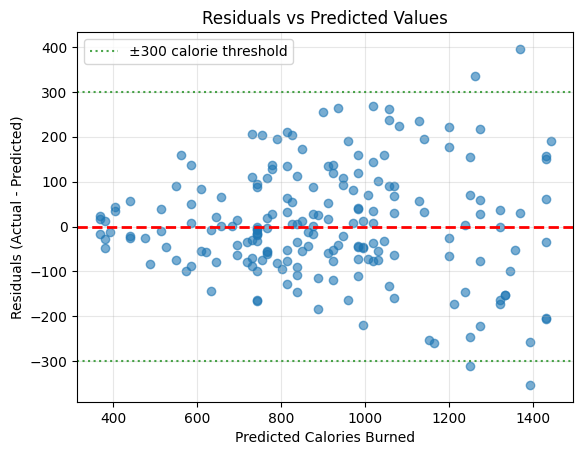

Residuals range: -352.6464964834893 to 395.4951754072297
Number of non-zero residuals: 195


In [21]:


residuals_linear = y_test - y_pred
plt.scatter(y_pred, residuals_linear, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Calories Burned')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)


plt.axhline(y=300, color='green', linestyle=':', alpha=0.7, label='±300 calorie threshold')
plt.axhline(y=-300, color='green', linestyle=':', alpha=0.7)
plt.legend()
plt.show()

print(f"Residuals range: {residuals_linear.min()} to {residuals_linear.max()}")
print(f"Number of non-zero residuals: {np.count_nonzero(residuals_linear)}")


#### Interpretatin
Both models demonstrat similar performance R² value around 0.82. The Huber method is slightly better, but not significant difference. This indicating that approximately 82% of the variance in calories burned is explained by the session duration. Given that calorie expenditure is influenced by multiple individual-specific factors (such as age, weight, intensity, fitness level, and metabolism), this level is considered satisfying in real-world, behavioral health data.


Both models predict slightly negative calories at zero session duration, which is physiologically unrealistic but statistically common in regression. The small difference (-1.94 calories) between models suggests consistent baseline estimates.

The Huber regression has slightly higher MSE (+51.70), suggesting linear regression performs marginally better at minimizing large prediction errors.

The MAE values are virtually identical, indicating both models have similar average prediction accuracy.

The coefficients are nearly identical, indicating both models found the same fundamental relationship: approximately 12 calories burned per minute of exercise.

While the model performs well on average (MAE ~95) and RMSE (125 ), the presence of large residuals (±350-395) indicates room for improvement. These extreme cases suggest that session duration alone, while a good predictor, cannot capture all factors affecting calorie burn for certain individuals or workout types.

This represents roughly 25-30% error for typical workout calorie burns.

RMSE helps to understand that while an average error is 95 calories, the model's tendency to occasionally make larger errors pushes the "typical weighted error" to 125 calories.

Since the model uses only one predictor (session_duration_(mins)), feature selection is not required. The simple linear regression shows no signs of overfitting, and therefore, regularization methods such as Ridge, Lasso, or ElasticNet are unnecessary in this case.

Normalization is also not needed because the model has only one feature, so scaling won’t affect the results.




### 3.7 Logistic regression

Logistic Regression is a simple, interpretable model that works well for linearly separable data. Thats why it was chosen for a baseline and to serve as a benchmark. A comparison of Logistic Regression model with and without fine-tuning of its hyperparameters is performed to determine if optimizing the model's settings would improve its performance. Standard evaluation metrics will be used to determine how good is the model.

The Random Forest classification model was chosen for the project as a alternative to Logistic Regression.. Random Forest is a more complex model that can capture non-linear relationships in the data, which a simpler model like Logistic Regression might miss and is generally more robust to overfitting. It should capture complex interactions between different variables.

In [26]:

df1['calories_class'] = pd.cut(
    df1['calories_burned'],
    bins=[-1, 700, 1200, df1['calories_burned'].max()],
    labels=['Low', 'Medium', 'High']
)

#Manually adding features
features = [
    'age',
    'gender',
    'weight_(kg)',
    'height_(m)',
    'max_bpm',
    'avg_bpm',
    'resting_bpm',
    'session_duration_(mins)',
    'workout_type',
    'fat_percentage',
    'water_intake_(liters)',
    'workout_frequency_(days/week)',
    'experience_level',
    'bmi',
]

X = df1[features]
y = df1['calories_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Preprocessing data
numeric_features = [
    'age', 'weight_(kg)', 'height_(m)', 'max_bpm', 'avg_bpm', 'resting_bpm',
    'session_duration_(mins)', 'fat_percentage', 'water_intake_(liters)',
    'workout_frequency_(days/week)', 'bmi'
]
categorical_features = ['gender', 'workout_type', 'experience_level']



categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # Fills missing values with the most common category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))      # Converts categories to binary variables
])


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Fill NaN with mean
    ('scaler', StandardScaler())                   #Standartizing (x-mean / std)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)




pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


#Model for train and test data
pipeline.fit(X_train, y_train)


y_pred_test = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

print("Classification Report for test data:")
print(classification_report(y_test, y_pred_test))

print()
print("Classification Report for tained data:")
print(classification_report(y_train, y_pred_train))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Classification Report for test data:
              precision    recall  f1-score   support

        High       0.91      0.81      0.86        26
         Low       0.95      0.91      0.93        44
      Medium       0.93      0.97      0.95       125

    accuracy                           0.93       195
   macro avg       0.93      0.89      0.91       195
weighted avg       0.93      0.93      0.93       195


Classification Report for tained data:
              precision    recall  f1-score   support

        High       0.95      0.90      0.92       106
         Low       0.98      0.93      0.96       173
      Medium       0.96      0.98      0.97       499

    accuracy                           0.96       778
   macro avg       0.96      0.94      0.95       778
weighted avg       0.96      0.96      0.96       778

Confusion Matrix:
[[ 21   0   5]
 [  0  40   4]
 [  2   2 121]]


There is only a small difference between the performance on the training data (96% accuracy) and the test data (93% accuracy). This suggests that the model is generalizing well to unseen data and does not show strong signs of overfitting.

##### performing hyperparameter tuning

In [27]:


param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization strength
    'classifier__penalty': ['l1', 'l2'],              # Type of regularization
    'classifier__solver': ['liblinear', 'saga'],      # Solvers that support L1/L2
    'classifier__class_weight': [None, 'balanced']    # Handle imbalanced classes
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                        # 5-fold cross-validation
    scoring='f1_macro',          # Macro F1 since 3 classes are available
    n_jobs=-1,                   # Use all CPU cores
    verbose=2                    # Show progress
)


grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)


print("Best CV Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)


print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_pred_test))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best CV Score: 0.9460971679028223

Classification Report (Test Data):
              precision    recall  f1-score   support

        High       0.91      0.81      0.86        26
         Low       0.95      0.95      0.95        44
      Medium       0.95      0.97      0.96       125

    accuracy                           0.94       195
   macro avg       0.94      0.91      0.92       195
weighted avg       0.94      0.94      0.94       195


Confusion Matrix (Test Data):
[[ 21   0   5]
 [  0  42   2]
 [  2   2 121]]


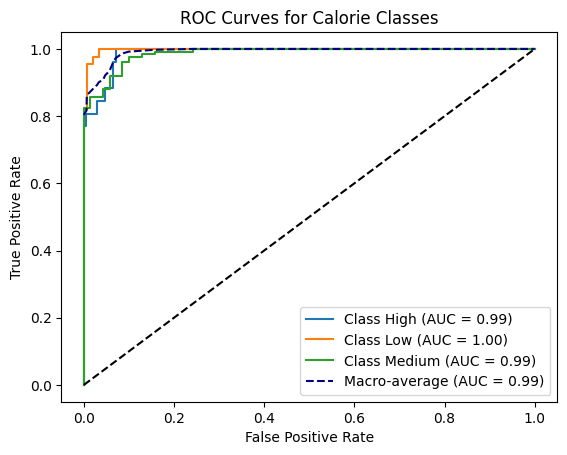

Per-Class AUC Scores: {'High': np.float64(0.9890760127446517), 'Low': np.float64(0.99789283564118), 'Medium': np.float64(0.9869714285714285)}
Macro-Average AUC: 0.9921045520319511


In [35]:


y_score = grid_search.predict_proba(X_test)

# Binarize the output for multi-class ROC
classes = grid_search.classes_  # low, medium, high
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)



for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(all_fpr, mean_tpr,
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle='--', color='navy')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Calorie Classes')
plt.legend()
plt.show()

print("Per-Class AUC Scores:", {classes[i]: roc_auc[i] for i in range(n_classes)})
print("Macro-Average AUC:", roc_auc["macro"])


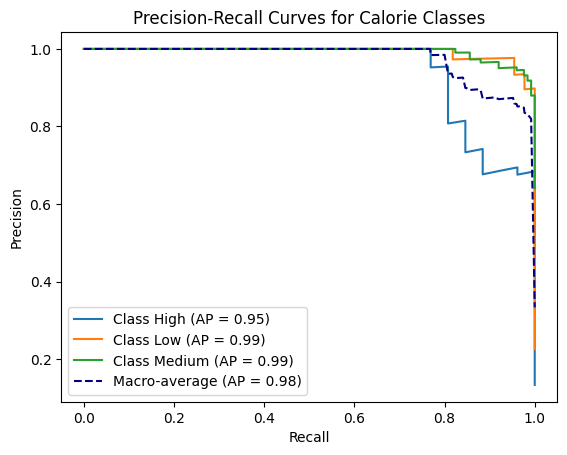

Per-Class Average Precision: {'High': np.float64(0.9452178849886829), 'Low': np.float64(0.9928256680815672), 'Medium': np.float64(0.9927264877858637)}
Macro-Average Precision: 0.976923346952038


In [36]:


# Precision-Recall curve and Average Precision (AP) for each class
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Macro-average Precision-Recall curve
all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
mean_precision = np.zeros_like(all_recall)
for i in range(n_classes):
    mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
mean_precision /= n_classes
avg_precision["macro"] = np.mean(list(avg_precision.values()))



for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label=f'Class {classes[i]} (AP = {avg_precision[i]:.2f})')
plt.plot(all_recall, mean_precision,
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})',
         linestyle='--', color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Calorie Classes')
plt.legend()
plt.show()

print("Per-Class Average Precision:", {classes[i]: avg_precision[i] for i in range(n_classes)})
print("Macro-Average Precision:", avg_precision["macro"])


#### Interpretation 

1. The model’s accuracy on the test data improved from 93% to 94% after hyperparameter tuning.

2. Precision, recall, and F1-scores for all classes (High, Low, Medium) also increased slightly, especially for the Low class (recall improved from 0.91 to 0.95).

3. The improvement is consistent across classes, which suggests the model is now better balanced and less biased toward the dominant class (Medium).

4. Confusion Matrix reveal strong performance on “Low” and “Medium” calorie classes, but lower recall/precision for “High” class.

5. The high scores of  Per-Class AUC ('High': 0.9890, 'Low': 0.9978, 'Medium': 0.9896) suggest that the mnodel is strong at distinguishing each individual class from the others.It also indicates that the model is robust and not just guessing the most frequent class.
   
6. The high scores of Per-Class Average Precision ('High': 0.9445, 'Low': 0.9928, 'Medium': 0.9927) means that when the model predicts a data point belongs to a specific class, it is highly likely to be correct.

7. The high score of Macro-Average Precision: 0.9769  and macro-average curve AUC of 0.9921 are good indicators of well-balanced model, which is not only precise on average but also performs well for all classes. This is a strong result that supports the conclusion that Logistic Regression is a robust model for this dataset.

### 3.8 Random Forest classification

In [26]:


param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced']
}

pipeline1 = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


grid_search = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv=5,                        # 5-fold cross-validation
    scoring='f1_macro',          # Macro F1 because 3 classes are available
    n_jobs=-1,                   # Use all CPU cores
    verbose=2                    # Show progress
)


grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)


print("Best CV Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

print()
print("Classification Report for tained data:")
print(classification_report(y_train, y_pred_train))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_pred_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best CV Score: 0.8720978127533152

Classification Report (Test Data):
              precision    recall  f1-score   support

        High       0.67      0.62      0.64        26
         Low       0.94      0.77      0.85        44
      Medium       0.85      0.92      0.88       125

    accuracy                           0.85       195
   macro avg       0.82      0.77      0.79       195
weighted avg       0.85      0.85      0.84       195


Classification Report for tained data:
              precision    recall  f1-score   support

        High       1.00      0.89      0.94       106
         Low       0.96      0.92      0.94       173
      Medium       0.95      0.99      0.97       499

    accuracy                           

#### Interpretation for Random Forest model

1. Training accuracy (96%) is much higher than test accuracy (85%), which indicates a risk of overfitting — the model performs very well on training data but less well on unseen data.

2. The gap between training recall for High (0.89) and test recall for High (0.62) further suggests that the model fails to generalize minority class patterns.

3. The Medium class is predicted with high precision and recall (0.85–0.92 on test), showing that the model is strong at identifying the majority class.

4. The High class shows weak performance on test data (precision = 0.67, recall = 0.62), meaning the model struggles with underrepresented classes.

5. Overall, the Random Forest model has strong predictive ability on training data but reduced generalization on test data, suggesting the need for class balancing techniques (e.g., SMOTE, class weighting) to improve minority class prediction.




#### General interpretation
1. Logistic Regression outperforms Random Forest on test accuracy (94% vs 85%) and provides more consistent results across all classes.

2. Random Forest shows signs of overfitting (96% training vs 85% test), while Logistic Regression generalizes better.

3. Minority class (“High”) is much better captured by Logistic Regression (0.91 precision, 0.81 recall) compared to Random Forest (0.67 precision, 0.62 recall).

4. Logistic Regression maintains balanced recall across "High," "Low," and "Medium," while Random Forest struggles especially with minority classes.

**Logistic Regression is the preferred model for this dataset due to its higher accuracy, stronger generalization, and better handling of all classes.**


## 4. References 

[1] https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

[2] https://www.kaggle.com/datasets/neethaporathurjoseph/workout-fitness-tracker-data/

[3] https://www.investopedia.com/terms/h/hypothesistesting.asp

[4] https://datatab.de/tutorial/t-test

[5] https://datatab.de/tutorial/varianzanalyse

[6] https://datatab.net/tutorial/chi-square-test

[7] https://www.geeksforgeeks.org/machine-learning/huberregressor-vs-ridge-on-dataset-with-strong-outliers-in-scikit-learn/

[8] https://www.geeksforgeeks.org/machine-learning/logistic-regression-vs-random-forest-classifier/abs

[9] https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/abs
